# Validate with confirmed MPOX images taken in the field

## Imports and Setup

In [2]:
from eccore.ipython import nb_setup
nb_setup()

import matplotlib.pyplot as plt
import torch

from IPython.display import Markdown, display
from pathlib import Path


from fastai import __version__ as fastai_version
from fastai.vision.all import *

from utils import run_experiment, create_image_features, plot_features, parse_saved_fnames, ROOT, DATASETS
from utils import validate_models, plot_training_and_validation_metrics, model_weight_files

print(f"Using fastai version {fastai_version}")
saved = ROOT / "saved"
data = ROOT / "data"

train_ds = "msld-v1"
p2train_ds = DATASETS[train_ds]['path']
assert p2train_ds.is_dir(), f"Training dataset path {p2train_ds} is not a directory."

test_ds = "ipp-augmented"
p2test_ds = DATASETS[test_ds]['path']
assert p2test_ds.is_dir(), f"Training test path {p2test_ds} is not a directory."
print(f"This notebook will use `{test_ds}` test dataset ({p2test_ds})")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# styles = plt.style.available
plt.style.use('default')

Added path: /home/vtec/projects/bio/mpox-prestudy/src
Set autoreload mode
Using fastai version 2.8.4
This notebook will use `ipp-augmented` test dataset (/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented)
Using device: cuda


Quick review of the training dataset

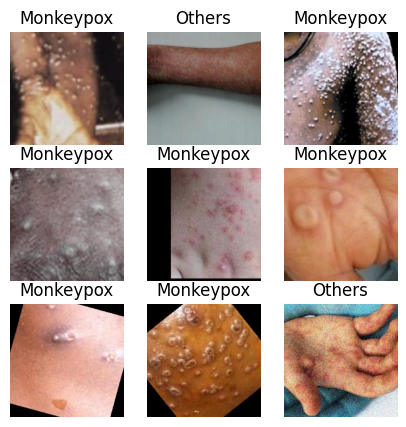

In [3]:
dls = ImageDataLoaders.from_folder(
    path=p2train_ds,
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
dls.show_batch(max_n=9, figsize=(5,5), show=True)

In [4]:
arch = resnet18
files = model_weight_files(arch=arch, dataset=train_ds)
files

[Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf.pth')]

File 0 has the best training validationn F1 and file 2 has the best training validation accuracy

['Monkeypox', 'Others']

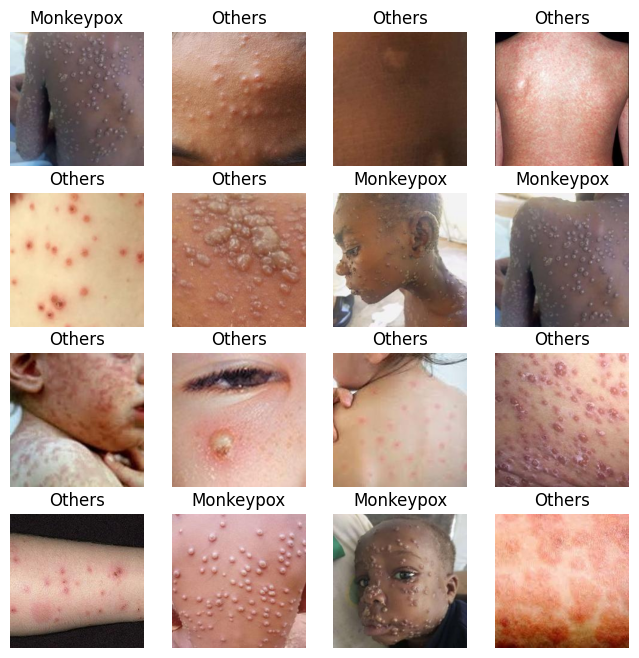

In [5]:
test_dls = ImageDataLoaders.from_folder(
    # p2test_ds/'Monkeypox',
    p2test_ds,
    valid_pct=1e-6,
    bs=32,
    item_tfms=Resize(224),
    drop_last=False,
    shuffle=False
)

test_dls.show_batch(max_n=16, figsize=(8,8), show=True)
test_dls.vocab

In [6]:
for file in files:
    m = parse_saved_fnames(file)
    print(m)
    p = file.parent/f"{m['model']}_{m['epoch']}_{m['bs']}_{m['lr']}_{m['ds']}_metadata_{m['uid']}.txt"
    print(p)
    print(p.read_text())

{'model': 'resnet18', 'epoch': '200', 'bs': '32', 'lr': '1.0e-03', 'ds': 'msld-v1', 'type': 'weights', 'uid': 'c229fec0-b6c1-4056-a779-90d602af250b', 'ext': 'pth'}
/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_metadata_c229fec0-b6c1-4056-a779-90d602af250b.txt
Finetuning Run Info:

Freeze Epochs: 1
Epochs: 200
Batch Size: 32
Learning Rate: 1.0e-03
Metrics:
	recall_score: 0.994366
	precision_score: 0.980556
	accuracy: 0.985893
	f1_score: 0.987413

UID: c229fec0-b6c1-4056-a779-90d602af250b
{'model': 'resnet18', 'epoch': '200', 'bs': '16', 'lr': '1.0e-03', 'ds': 'msld-v1', 'type': 'weights', 'uid': '532b8eaf-f82c-476b-bf73-f5c084e743d8', 'ext': 'pth'}
/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_16_1.0e-03_msld-v1_metadata_532b8eaf-f82c-476b-bf73-f5c084e743d8.txt
Finetuning Run Info:

Freeze Epochs: 1
Epochs: 200
Batch Size: 16
Learning Rate: 1.0e-03
Metrics:
	recall_score: 1.000000
	precision_score: 0.967302
	accuracy: 0.981191
	f1_score: 0.983380

In [7]:
n=0
learn = vision_learner(
    dls,
    arch,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy]
    # metrics=[Recall(), Precision(), accuracy, F1Score()]
)
print(f"Loading weights from {files[n]}")
load_model(file=files[n], model=learn.model,opt=learn.opt, with_opt=False)


Loading weights from /home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b.pth


Inference for all images

In [8]:
test_dl = test_dls.train
true_labels = torch.cat([lbl for img,lbl in iter(test_dl)]).detach().cpu()

probs, _ = learn.get_preds(dl=test_dl)

preds = torch.argmax(probs, dim=1)
preds = preds.detach().cpu()
accuracy(probs, true_labels), Precision(pos_label=0)(preds, true_labels), Recall(pos_label=0)(preds, true_labels), F1Score(pos_label=0)(preds, true_labels)

(TensorBase(0.6389), 1.0, 0.13333333333333333, 0.23529411764705882)

In [9]:
print(f"Accuracy ............... : {accuracy(probs, true_labels).numpy()}")
print(f"Classed Balanced Accuracy: {BalancedAccuracy()(preds=preds, targs=true_labels)}")
print(f"Precision on MPOX:         {Precision(pos_label=0, average='binary')(preds=preds, targs=true_labels)}")
print(f"Recall on MPOX:            {Recall(pos_label=0, average='binary')(preds=preds, targs=true_labels)}")
print(f"Precision on Others:       {Precision(pos_label=1, average='binary')(preds=preds, targs=true_labels)}")
print(f"Recall on Others:          {Recall(pos_label=1, average='binary')(preds=preds, targs=true_labels)}")
print(f"F1 on MPOX:                {F1Score(pos_label=0, average='binary')(preds=preds, targs=true_labels)}")
print(f"F1 on Others:              {F1Score(pos_label=1, average='binary')(preds=preds, targs=true_labels)}")

Accuracy ............... : 0.6388888955116272
Classed Balanced Accuracy: 0.5666666666666667
Precision on MPOX:         1.0
Recall on MPOX:            0.13333333333333333
Precision on Others:       0.6176470588235294
Recall on Others:          1.0
F1 on MPOX:                0.23529411764705882
F1 on Others:              0.7636363636363637


In [10]:
i = ClassificationInterpretation.from_learner(learn, dl=test_dls.train)
i.confusion_matrix()

array([[ 12,  78],
       [  0, 126]])

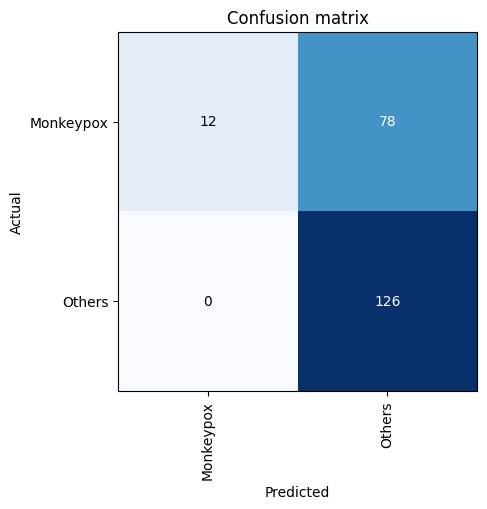

In [11]:
i.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [18]:
test_dls.train_ds

(#216) [(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PIL

In [43]:
accurate_preds = preds == true_labels
print(f"Total samples: {preds.shape[0]}, Accurate predictions: {accurate_preds.sum()}")
mask_mpox = true_labels == 0
mask_others = true_labels == 1
print(f"MPOX: {sum(mask_mpox)}, Others: {sum(mask_others)}")
accurate_preds_mpox = accurate_preds[mask_mpox]
accurate_preds_others = accurate_preds[mask_others]
accurate_preds.sum() / preds.shape[0], accurate_preds_mpox.sum() / preds[mask_mpox].shape[0], accurate_preds_others.sum() / preds[mask_others].shape[0]

Total samples: 216, Accurate predictions: TensorCategory(138)
MPOX: TensorCategory(90), Others: TensorCategory(126)


(TensorCategory(0.6389), TensorCategory(0.1333), TensorCategory(1.))

[Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Monkeypox/20250828085823_63_general_01.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM52_01.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM54_02.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM29_01.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM101_01.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM58_02.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Monkeypox/20250828085704_55_general_07.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Monkeypox/20250828085823_63_general_08.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM05_01.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM84_01.jpg'), Path('/home/vtec/projects/bio/mpox-prestudy/data/ipp/augmented/Others/NM03_0

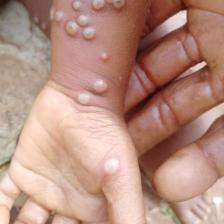

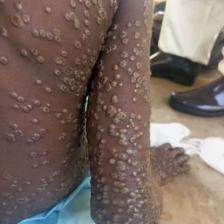

In [48]:
test_imgs = [fname for fname in test_dls.train_ds.items]
test_imgs_files = get_image_files(p2test_ds)
print(test_imgs)
assert len(test_imgs) == len(accurate_preds)

correct = sorted([f for f, acc in zip(test_imgs, accurate_preds) if acc.item()])
errors = sorted([f for f, acc in zip(test_imgs, accurate_preds) if not acc.item()])
print(len(correct),len(errors))

correct_mpox = [f for f in correct if 'Monkeypox' in str(f)]
correct_others = [f for f in correct if 'Monkeypox' not in str(f)]
correct_mpox

display(Image.open(correct_mpox[0]))
display(Image.open(correct_mpox[-1]))

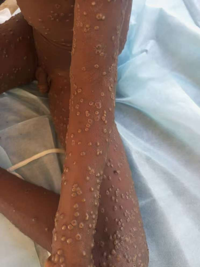

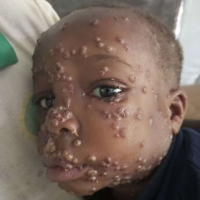

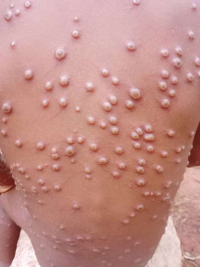

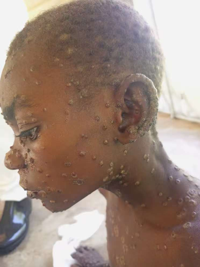

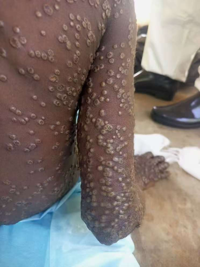

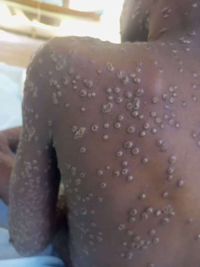

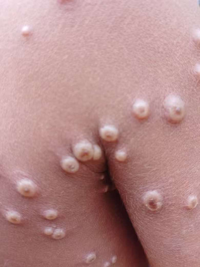

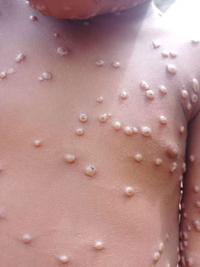

In [55]:
from PIL import ImageOps

errors_mpox = [f for f in errors if 'Monkeypox' in str(f)]
errors_mpox

original_image = set([f.name[:17] for f in errors_mpox])
original_image

for e in original_image:
    fname = DATASETS['ipp-original']['path']/f"{e}.jpg"
    assert fname.is_file(), f"File {fname} does not exist."
    display(ImageOps.cover(Image.open(fname), (200, 200)))
# display(Image.open(correct_mpox[0]))
# display(Image.open(correct_mpox[-1]))